In [113]:
import os
import requests
from datetime import datetime

from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cdc_wrapper import CDC

In [104]:
load_dotenv()

api_key = os.getenv('CDCEX_API')
secret_key = os.getenv('CDCEX_SECRET')

cdc = CDC(api_key=api_key, secret_key=secret_key, sandbox=False)
data = cdc.get_candlesticks('ETHUSD-PERP', '1D', 365)
# data

In [105]:
df = pd.DataFrame(data)
df['dt'] = pd.to_datetime(df['t'], unit='ms')
df['o'] = df['o'].astype(float)
df['h'] = df['h'].astype(float)
df['l'] = df['l'].astype(float)
df['c'] = df['c'].astype(float)
df['v'] = df['v'].astype(float)
df['date'] = df['dt'].dt.date
df.head()

,o,h,l,c,v,t,dt,date
0,1667.49,1669.19,1580.16,1634.10,48190.4686,1692662400000,2023-08-22,2023-08-22
1,1634.36,1701.60,1628.65,1679.21,61978.0377,1692748800000,2023-08-23,2023-08-23
2,1679.18,1683.26,1635.13,1660.59,44583.0578,1692835200000,2023-08-24,2023-08-24
3,1660.64,1676.45,1634.86,1653.28,51075.1499,1692921600000,2023-08-25,2023-08-25
4,1653.32,1655.21,1643.43,1646.41,11100.6098,1693008000000,2023-08-26,2023-08-26


In [97]:
base_url = 'https://api.alternative.me/'
endpoint = 'fng/'
limit = 365

request = f'{base_url}{endpoint}?limit={limit}&format=json&date_format=cn'

response = requests.get(request).json()
fng_data = response['data']

fng_df = pd.DataFrame.from_records(fng_data)
fng_df['date'] = pd.to_datetime(fng_df['timestamp']).dt.date
fng_df = fng_df.drop(columns=['time_until_update', 'timestamp'])

fng_df['value'] = pd.to_numeric(fng_df['value'])

print(fng_df)


     value value_classification        date
0       71                Greed  2024-06-16
1       74                Greed  2024-06-15
2       74                Greed  2024-06-14
3       70                Greed  2024-06-13
4       72                Greed  2024-06-12
..     ...                  ...         ...
360     65                Greed  2023-06-22
361     59                Greed  2023-06-21
362     49              Neutral  2023-06-20
363     47              Neutral  2023-06-19
364     49              Neutral  2023-06-18

[365 rows x 3 columns]


In [122]:


class Position:
    def __init__(self, instrument, open_price, stop_loss, take_profit, qty, direction):
        self.instrument = instrument
        self.open_price = open_price
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.qty = qty
        # short or long
        self.direction = direction
        self.status = 'open'

    def calculate_cost(self):
        return (self.open_price * self.qty)

    def close_position(self, action) -> float:
        self.status = 'closed'
        if action == 'sl':
            if self.direction == 'long':
                return ((self.stop_loss * self.qty) - self.calculate_cost())
            if self.direction == 'short':
                return -((self.stop_loss * self.qty) - self.calculate_cost())
        elif action == 'tp':
            if self.direction == 'long':
                return ((self.take_profit * self.qty) - self.calculate_cost())
            if self.direction == 'short':
                return -((self.take_profit * self.qty) - self.calculate_cost())

def generate_indicators(df):
    temp_df = df.copy()
    # temp_df['ma50'] = temp_df['c'].rolling(50).mean()
    # temp_df['ma100'] = temp_df['c'].rolling(100).mean()
    temp_df = temp_df.merge(fng_df, how='left', on='date')
    temp_df = temp_df.rename({
        'value_classification': 'fng_cls',
        'value': 'fng'
    }, axis=1)

    return temp_df

# random for now, just to test
def calculate_trade(row):
    rng = np.random.rand()
    if rng < 0.8:
        return {
            'decision': 'no trade',
            'stop loss': 'na',
            'take profit': 'na'
        }
    else:
        if rng < 0.4:
            return {
                'decision': 'short',
                'stop loss': row['c'] * 1.1,
                'take profit': row['c'] * 0.8
            }
        else:
            return {
                'decision': 'long',
                'stop loss': row['c'] * 0.9,
                'take profit': row['c'] * 1.2
            }

In [128]:
test_df = generate_indicators(df).copy()
test_df['c_1'] = test_df['c'].shift(1)
test_df['c_rel'] = test_df['c'] / test_df['c_1'] - 1
test_df['c_7'] = test_df['c'].shift(7)
test_df['c_rel7'] = test_df['c'] / test_df['c_7'] - 1
test_df['fng_cls_label'] = test_df['fng_cls'].replace({
    'Extreme Fear': '1. Extreme Fear',
    'Fear': '2. Fear',
    'Neutral': '3. Neutral',
    'Greed': '4. Greed',
    'Extreme Greed': '5. Extreme Greed'
})
test_df['fng_cls_label_1'] = test_df['fng_cls_label'].shift(1)
test_df = test_df.dropna()
test_df.groupby('fng_cls_label')['c_rel7'].mean()

fng_cls_label
2. Fear            -0.012492
3. Neutral         -0.012321
4. Greed            0.023119
5. Extreme Greed    0.062555
Name: c_rel7, dtype: float64

In [132]:
test_df.groupby('fng_cls_label_1')['c_rel7'].mean()

fng_cls_label_1
2. Fear            -0.004803
3. Neutral         -0.010148
4. Greed            0.023219
5. Extreme Greed    0.056270
Name: c_rel7, dtype: float64

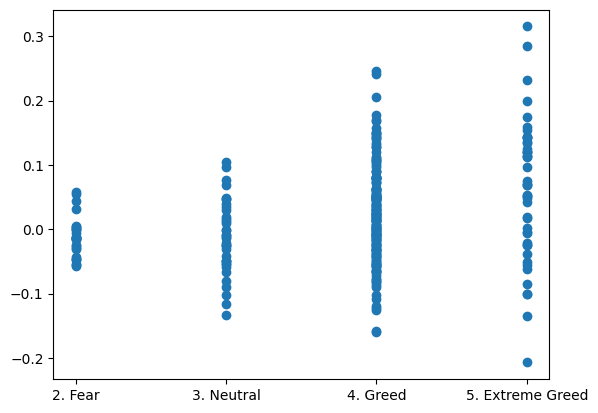

In [130]:
plt.scatter(test_df['fng_cls_label'], test_df['c_rel7'])

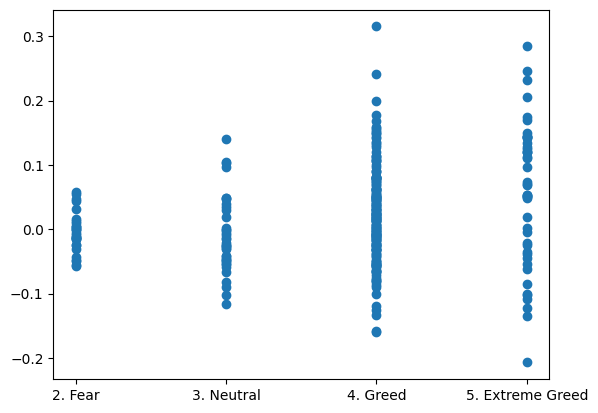

In [131]:
plt.scatter(test_df['fng_cls_label_1'], test_df['c_rel7'])

In [83]:
positions = []
closed_positions = []

capital = 10000
risk_perc = 0.01
max_positions = 10

test_df = generate_indicators(df)
test_df.dropna()

for index, row in test_df.iterrows():
    # decide if profit taken or stop triggered
    if len(positions):
        low_price = row['l']
        high_price = row['h']
        for position in positions:
            if position.direction == 'long':
                # prioritize stopping out first (i.e. conservative)
                if low_price <= position.stop_loss:
                    capital += position.close_position('sl')
                    print(f'{row["dt"]}: Position hit stop loss.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
                if high_price >= position.take_profit:
                    capital += position.close_position('tp')
                    print(f'{row["dt"]}: Position hit take profit.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
            if position.direction == 'short':
                if high_price >= position.stop_loss:
                    capital += position.close_position('sl')
                    print(f'{row["dt"]}: Position hit stop loss.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
                if low_price <= position.take_profit:
                    capital += position.close_position('tp')
                    print(f'{row["dt"]}: Position hit take profit.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue

    # decide capital amount to use
    risk_val = risk_perc * capital

    # once positions are settled, decide whether to open new position or not
    if len(positions) < max_positions:

        result = calculate_trade(row)
        if result['decision'] == 'no trade':
            continue
        else:
            instrument = 'test instrument'
            open_price = row['c']
            stop_loss = result['stop loss']
            take_profit = result['take profit']
            direction = result['decision']
            qty = risk_val / open_price
            new_position = Position(instrument, open_price, stop_loss, take_profit, qty, direction)
            positions.append(new_position)




2024-04-30 16:00:00: Position hit stop loss.
Capital: 9990.0
2024-05-01 08:00:00: Position hit stop loss.
Capital: 9980.0
2024-05-14 16:00:00: Position hit stop loss.
Capital: 9970.02
2024-05-20 20:00:00: Position hit take profit.
Capital: 9990.0
2024-05-20 20:00:00: Position hit take profit.
Capital: 10009.96
2024-05-20 20:00:00: Position hit take profit.
Capital: 10029.919999999998
2024-05-21 00:00:00: Position hit take profit.
Capital: 10049.879999999997
2024-05-21 00:00:00: Position hit take profit.
Capital: 10069.839999999997
2024-05-21 00:00:00: Position hit take profit.
Capital: 10089.780039999996
2024-05-21 04:00:00: Position hit take profit.
Capital: 10109.740039999995
2024-05-21 08:00:00: Position hit take profit.
Capital: 10129.700039999994
2024-05-21 08:00:00: Position hit take profit.
Capital: 10149.660039999993
2024-05-21 12:00:00: Position hit take profit.
Capital: 10169.620039999993
2024-06-11 00:00:00: Position hit stop loss.
Capital: 10159.450419959992
2024-06-11 12:0

In [50]:
a = ['a', 'b', 'c']
a.remove('b')
a

['a', 'c']